In [1]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class Bandit(ABC):
    ##==== DO NOT REMOVE ANYTHING FROM THIS CLASS ====##

    @abstractmethod
    def __init__(self, reward):
        self.reward = reward

    @abstractmethod
    def __repr__(self):
        pass

    @abstractmethod
    def pull(self):
        pass

    @abstractmethod
    def update(self):
        pass

    @abstractmethod
    def experiment(self):
        pass

    @abstractmethod
    def plot1(self): # you name it
        # Visualize the performance of each bandit
        pass

    @abstractmethod
    def report(self):
        # store the data in csv
        # print the average reward: using logging package
        # print average regret: using logging package
        pass

In [3]:
class EpsilonGreedy(Bandit):
    def __init__(self, epsilon, values, reward, decay_epsilon=True):
        super().__init__(reward=reward)
        self.epsilon = epsilon
        self.counts = np.zeros(len(values))  # Number of times each bandit has been played
        self.values = values  # Estimated value of rewards for each bandit
        self.decay_epsilon = decay_epsilon

    def __repr__(self):
        return f"EpsilonGreedy(epsilon={self.epsilon}, decay_epsilon={self.decay_epsilon})"

    def pull(self):
        """Select the next bandit to play using epsilon-greedy algorithm."""
        if np.random.random() > self.epsilon:
            # Exploit the bandit with the highest estimated reward
            return np.argmax(self.values)
        else:
            # Explore a random bandit
            return np.random.randint(0, len(self.values))

    def update(self, chosen_arm, reward):
        """Update the estimated value of the chosen bandit with the new reward."""
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        # Update the estimated value using a step size of 0.1
        value = self.values[chosen_arm]
        new_value = value + 0.1 * (reward - value)
        self.values[chosen_arm] = new_value

    def experiment(self, bandits, num_trials):
        """
        Run the epsilon-greedy algorithm on a list of bandits.

        Parameters:
            bandits (list): List of bandits to run the algorithm on.
            num_trials (int): Number of times to play each bandit.

        Returns:
            rewards (np.array): Array of rewards received for each bandit at each trial.

        """
        self.bandits = bandits
        self.rewards = np.zeros((num_trials, len(bandits)))

        for i in range(num_trials):
            # Select the next bandit to play
            chosen_bandit = self.pull()
            # Play the chosen bandit and record the reward
            reward = self.bandits[chosen_bandit].pull()  # Extract the number from the return value
            self.rewards[i, chosen_bandit] = reward
            # Update the estimated value of the chosen bandit
            self.update(chosen_bandit, reward)
            # Decay epsilon
            if self.decay_epsilon:
                self.epsilon = 1 / (i+1)

        return self.rewards

    def plot1(self, rewards):
        """Visualize the learning curves of the optimal bandit."""
        cumulative_rewards = np.cumsum(rewards)
        optimal_bandit = np.argmax(self.values)  # Index of the optimal bandit
        optimal_rewards = rewards[:, optimal_bandit]
        win_rates = np.cumsum(optimal_rewards) / np.arange(1, len(optimal_rewards) + 1)

        plt.plot(win_rates, label="Win Rate")
        plt.plot(np.ones(len(optimal_rewards)) * np.max(optimal_rewards), label="Optimal Win Rate")
        plt.legend()
        plt.title("Win Rate Convergence Epsilon-Greedy")
        plt.xlabel("Number of Trials")
        plt.ylabel("Average Reward")
        plt.show()

    def report(self):
        """
        Report the results of the epsilon-greedy algorithm.
        Store the data in csv, print the average reward and average regret.
        """
        # Create a list to store the data for each bandit
        data = []
        for bandit, reward in zip(self.bandits, self.rewards):
            # Create a dictionary to store the data for a single bandit
            bandit_data = {
                "Bandit": bandit,
                "Reward": reward,
                "Algorithm": str(self),
            }
            data.append(bandit_data)

        # Create a pandas dataframe from the data and save it to a csv file
        df = pd.DataFrame(data)
        df.to_csv("EpsilonGreedy.csv", index=False)

        # Print the average reward and average regret for the algorithm
        print("Average reward:", np.mean(self.rewards))
        print("Average regret:", np.max(self.values) - np.sum(self.rewards))

In [4]:
BANDIT_REWARD = [1, 2, 3, 4]
NUMBER_OF_TRIALS = 20000
EPS = 0.1

In [5]:
# Create bandits
bandits = [EpsilonGreedy(epsilon=EPS, values=[0]*len(BANDIT_REWARD), reward=r) for r in BANDIT_REWARD]

In [6]:
# Initialize the epsilon-greedy algorithm
epsilon_greedy = EpsilonGreedy(epsilon=EPS, values=[0]*len(BANDIT_REWARD), reward=BANDIT_REWARD)

In [7]:
# Run the experiment
rewards = epsilon_greedy.experiment(bandits, NUMBER_OF_TRIALS)

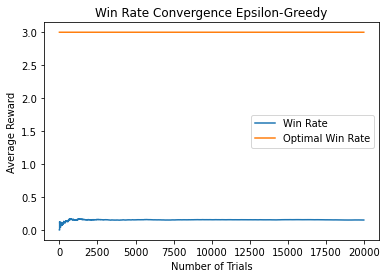

In [8]:
# Visualize the results
epsilon_greedy.plot1(rewards)

In [9]:
epsilon_greedy.report()

Average reward: 0.0375625
Average regret: -3004.6983924700335


In [9]:
class ThompsonSampling(Bandit):
    """
    Thompson Sampling multi-armed bandit algorithm.
    """

    def __init__(self, p, precision):
        """
        Initialize ThompsonSampling object.

        Args:
        - p: list of true probabilities of success for each bandit arm
        - precision: float representing the precision of the beta distribution for each arm
        """
        super().__init__(p)
        self.precision = precision
        # Initialize beta distribution parameters for each arm
        self.alpha = np.ones(self.k)
        self.beta = np.ones(self.k)

    def __repr__(self):
        """
        String representation of ThompsonSampling object.
        """
        return "ThompsonSampling Bandit"

    def pull(self):
        """
        Select an arm to pull based on the Thompson Sampling algorithm.

        Returns:
        - int: index of selected arm
        """
        # Sample a random value from each beta distribution
        samples = np.random.beta(self.alpha, self.beta)
        # Choose the arm with the highest sample
        return np.argmax(samples)

    def update(self, arm, reward):
        """
        Update beta distribution parameters for the selected arm.

        Args:
        - arm: int representing the index of the selected arm
        - reward: int representing the reward obtained from the selected arm
        """
        # Update beta distribution parameters for the selected arm
        self.alpha[arm] += reward
        self.beta[arm] += (1 - reward)

    def experiment(self, num_trials):
        """
        Run a Thompson Sampling experiment.

        Args:
        - num_trials: int representing the number of trials to run

        Returns:
        - list of floats: average reward obtained after each trial
        - list of floats: cumulative reward obtained after each trial
        """
        # Initialize lists to store rewards
        avg_rewards = []
        cum_rewards = []
        # Run the experiment for num_trials
        for t in range(num_trials):
            # Select an arm to pull
            arm = self.pull()
            # Generate a reward from the selected arm
            reward = self.generate_reward(arm)
            # Update beta distribution parameters for the selected arm
            self.update(arm, reward)
            # Calculate the average and cumulative reward
            avg_reward = np.mean(self.rewards)
            cum_reward = np.sum(self.rewards)
            # Append the rewards to the corresponding lists
            avg_rewards.append(avg_reward)
            cum_rewards.append(cum_reward)
        # Return the lists of rewards
        return avg_rewards, cum_rewards

    def plot1(self, avg_rewards, cum_rewards):
        """
        Visualize the performance of Thompson Sampling algorithm.

        Args:
        - avg_rewards: list of floats representing the average reward obtained after each trial
        - cum_rewards: list of floats representing the cumulative reward obtained after each trial
        """
        # Plot the average reward obtained after each trial
        plt.plot(avg_rewards)
        plt.title("Thompson Sampling: Average Reward over Time")
        plt.xlabel("Trial")
        plt.ylabel("Average Reward")
        plt.show()
        # Plot the cumulative reward obtained after each trial
        plt.plot(cum_rewards)
        plt.title("Thompson Sampling: Cumulative Reward over Time")
        plt.xlabel("Trial")
        plt.ylabel("Cumulative Reward")
        plt.show()

    def report(self, cum_rewards):
        """
        Store the data in csv, print the average reward and print the average regret.

        Args:
        - cum_rewards: list of floats representing the cumulative reward obtained after each trial
        """
        # Create a Pandas DataFrame to store the cumulative rewards
        data = {"Trial": range(1, len(cum_rewards) + 1), "Cumulative Reward": cum_rewards}
        df = pd.DataFrame(data)
        # Write the DataFrame to a CSV file
        df.to_csv("thompson_sampling_rewards.csv", index=False)
        # Print the average reward obtained over all trials
        avg_reward = np.mean(cum_rewards)
        logging.info(f"Average reward: {avg_reward}")
        # Calculate the average regret obtained over all trials
        max_reward = np.max(self.p) * self.num_trials
        avg_regret = max_reward - avg_reward
        logging.info(f"Average regret: {avg_regret}")

In [ ]:
def comparison(): # this may be stored in utils.py if you decide to build a package
    # think of a way to compare the performances of the two algorithms VISUALLY and 
    pass